In [10]:
# Rubens Guedes Kaiserman
# DRE: 122119151
# Att

# Fica uma observação Inicial: Você meio que não explicitou se queria uma medida de erro baseada na referência do scipy ou da esfera. Dado que da esfera era mais fácil de calcular. Fiz baseado na esfera. Deixei a referência do scipy apenas como auxílio visual.

# Fica a segunda observação que eu copiei algumas coisas do notebook da disciplina. Tal qual o método de Euler. Eu até poderia ter reescrito de lá com nomes de variáveis diferentes e tal. Mas não tem necessidade de ficar fugindo do óbvio. Afinal, o método de Euler é o método de Euler.
# Dito isso. 

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


$$
    x(t) = (x1 (t), x2 (t), x3 (t))^T \\
    F = (0, 0, −gm)^T \\
    g = -9.8 m/s \\
    \Phi(x) = x^2_1 + x^2_2 + x^2_3 − 1 = 0 \\ 
    \ddot{x} = \frac{1}{m}(F - \frac{m\dot{x}^T H \dot{x} + \nabla \Phi^T F}{|\nabla \Phi|^2} \nabla \Phi)  \\
$$

$$
    H = \begin{pmatrix}
                \frac{\partial^2 \Phi}{\partial x_1^2} & \frac{\partial^2 \Phi}{\partial x_1 \partial x_2} & \frac{\partial^2 \Phi}{\partial x_1 \partial x_3}\\
                \frac{\partial^2 \Phi}{\partial x_2 \partial x_1} & \frac{\partial^2 \Phi}{\partial x_2^2} & \frac{\partial^2 \Phi}{\partial x_2 \partial x_3}\\
                \frac{\partial^2 \Phi}{\partial x_3 \partial x_1} & \frac{\partial^2 \Phi}{\partial x_3 \partial x_2} & \frac{\partial^2 \Phi}{\partial x_3^2}\\
    \end{pmatrix} = \begin{pmatrix}
                        2 & 0 & 0\\
                        0 & 2 & 0 \\
                        0 & 0 & 2 \\
                    \end{pmatrix}

$$

To numerically solve (8.72) let us transform it into a system of differential equations of order 1 in the new variable y, a vector with 6 components. Having set $y_i = x_i$ and $y_{i+3}=\dot{x_i}$ with i = 1, 2, 3, and

$$
    \lambda = \frac{m(y_4, y_5, y_6)^T H (y_4, y_5, y_6) + \nabla \Phi^T F}{|\nabla \Phi|^2} \nabla \Phi  \\
    \dot{y_i} = y_{3+ i} \\
    \dot{y}_{3 + i} = \frac{1}{m}(F_i - \lambda \frac{\partial \Phi}{\partial y_i})
$$

In [11]:
def fvinc(t, y):
    f = y.copy()
    
    NABLA_PHI = [2 * y[0], 2 * y[1],2 * y[2]]
    M = 1
    H = 2 * np.eye(3)
    F = [0, 0, -M * 9.8]
    
    xp = np.zeros(3)
    xp[0:3] = y[3:6].flatten()
    
    F = np.array(F)
    G = np.array(NABLA_PHI)
    
    lambda_val = (M * xp @ H @ xp + F @ G) / (G @ G)
    
    f[0:3] = y[3:6]
    
    for k in range(3):
        f[k + 3] = (F[k] - lambda_val * G[k]) / M
    
    return f


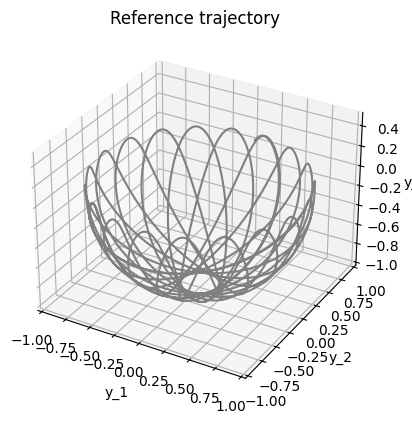

In [12]:
tspan = [0, 25]
y0 = np.array([0, 1, 0, 0.8, 0, 1.2])
y = solve_ivp(fvinc, tspan, y0, t_eval=np.arange(0, 25, 0.0025), method="RK45", max_step=0.0025)

y = y.y.T

x_reference = y[:, 0]
y_reference = y[:, 1]
z_reference = y[:, 2]


ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 0.5])

ax.set_xlabel('y_1')
ax.set_ylabel('y_2')
ax.set_zlabel('y_3')

ax.plot(x_reference, y_reference, z_reference, color='grey')
plt.title('Reference trajectory')

plt.show()

In [13]:
def plot_show(y, title):
    # Calcular quão fora da esfera nossa aproximação está
    error = [abs((y_i[0]**2 + y_i[1]**2 + y_i[2]**2) - 1) for y_i in y]

    print("Erro máximo com relação a esfera: ", max(error))
    print("Erro médio com relação a esfera: ", sum(error) / len(error))

    ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')

    y_1 = y[:, 0]
    y_2 = y[:, 1]
    y_3 = y[:, 2]

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 0.5])
    ax.plot(x_reference, y_reference, z_reference, color='grey', linestyle='dashed')
    ax.plot(y_1, y_2, y_3)
    plt.title(title)

    plt.show()

In [14]:

"""
    Eu copiando código do professor? Jamais!
"""
class BaseFixedStepIntegrator:
    """
    A base class for fixed-step integration methods.
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y0, t_eval=None):
        """
        Integrate the ODE y' = f(t, y) from t0 to tf using an integrator's update method
        """
        t0, tf = tspan

        # Create an array of time points to evaluate the solution
        if t_eval is None:
            t_eval = np.arange(t0, tf, self.dt)

        # Create an array to store the solution (pre-allocate)
        y = np.zeros((len(t_eval), len(y0)))

        # Set the initial condition
        y[0] = y0

        # Integrate the ODE
        self.error = []
        for i in range(1, len(t_eval)):
            t = t_eval[i - 1]
            y[i] = self.update(f, t, y[i - 1]) # this will be defined in the subclass
            
            if np.isnan(y[i]).any():
                break

        self.t, self.y = t_eval, np.array(y)
        return self

    def update(self, f, t, y):
        """
        Update the solution using the integrator's method
        """
        raise NotImplementedError("This method must be implemented in a subclass")

class Euler(BaseFixedStepIntegrator):
    """
    Note:
    super() calls the constructor of BaseIntegrator
    kwargs collects any passed keyword arguments and passes them on to the constructor 
    of BaseIntegrator
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        return y + self.dt * f(t, y)
    
    
class ImplicitEuler(BaseFixedStepIntegrator):
    """
    The implicit Euler method for integration without the Jacobian
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def fixed_point(self, f, t, y, tol=1e-6, max_iter=30):
        """
        Fixed-point iteration for solving nonlinear equations
        """
        y_old = y.copy()
        for i in range(max_iter):
            y_new = y + self.dt * f(t + self.dt, y_old) 
            if np.linalg.norm(y_new - y_old) < tol:
                break
            y_old = y_new
        return y_new
    
    def update(self, f, t, y):
        return self.fixed_point(f, t, y)


class CNMethod(BaseFixedStepIntegrator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def crank_nicolson_fun(self, w, f, t, y):
        dt = self.dt
        return w - y - 0.5 * dt * (f(t + dt, w) + f(t, y))

    def update(self, f, t, y):
        w_init = y  # Initial guess
        w = fsolve(self.crank_nicolson_fun, w_init, args=(f, t, y), full_output=True)[0]
        
        return w

    
class ode45(BaseFixedStepIntegrator):
    """
    The ode45 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 5, y + self.dt * k1 / 5)
        k3 = f(t + 3 * self.dt / 10, y + self.dt * (3 * k1 / 40 + 9 * k2 / 40))
        k4 = f(t + 4 * self.dt / 5, y + self.dt * (44 * k1 / 45 - 56 * k2 / 15 + 32 * k3 / 9))
        k5 = f(t + 8 * self.dt / 9, y + self.dt * (19372 * k1 / 6561 - 25360 * k2 / 2187 + 64448 * k3 / 6561 - 212 * k4 / 729))
        k6 = f(t + self.dt, y + self.dt * (9017 * k1 / 3168 - 355 * k2 / 33 + 46732 * k3 / 5247 + 49 * k4 / 176 - 5103 * k5 / 18656))
        
        return y + self.dt * (35 * k1 / 384 + 500 * k3 / 1113 + 125 * k4 / 192 - 2187 * k5 / 6784 + 11 * k6 / 84)
                              
class ode23(BaseFixedStepIntegrator):
    """
    The ode23 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + 2 / 3 * self.dt, y + 2 / 3 * self.dt * k1)
        return y + self.dt * (1 / 4 * k1 + 3 / 4 * k2)    



Erro máximo com relação a esfera:  1.0575119100538415
Erro médio com relação a esfera:  0.5391766764887768


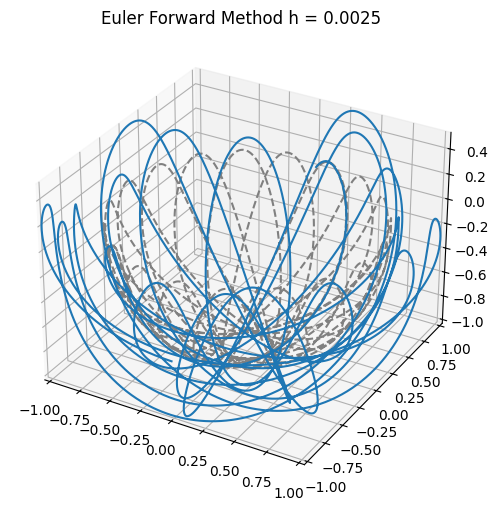

In [15]:
integrator = Euler(dt=0.0025)
integrator.integrate(fvinc, [0, 25], y0= np.array([0, 1, 0, 0.8, 0, 1.2]))

plot_show(integrator.y, "Euler Forward Method h = 0.0025")

Como podemos observar, como comentado no livro. O método de Euler explícito com passo 0.0025 deixa a desejar estando bem distante da referência em linha tracejada cinza e bem fora da esfera também

Erro máximo com relação a esfera:  0.11108151323525517
Erro médio com relação a esfera:  0.05553291570627093


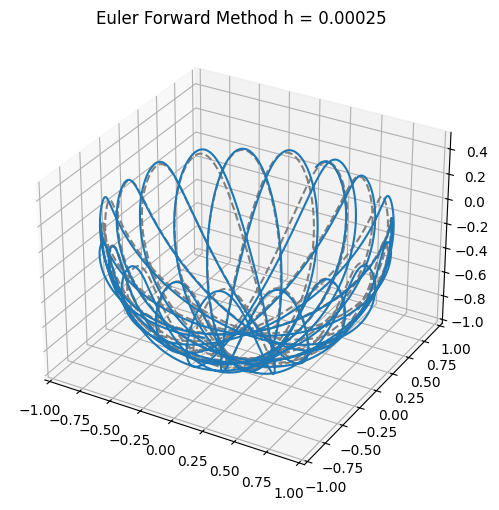

In [16]:
integrator = Euler(dt=0.00025)
integrator.integrate(fvinc, [0, 25], y0= np.array([0, 1, 0, 0.8, 0, 1.2]))

plot_show(integrator.y, "Euler Forward Method h = 0.00025")

Erro máximo com relação a esfera:  0.5815487336611577
Erro médio com relação a esfera:  0.28463875463929544


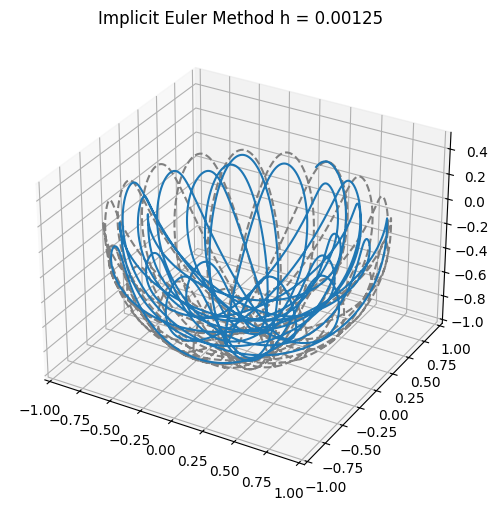

In [17]:
integrator = ImplicitEuler(dt=0.00125)
integrator.integrate(fvinc, [0, 25], y0= np.array([0, 1, 0, 0.8, 0, 1.2]))

plot_show(integrator.y, "Implicit Euler Method h = 0.00125")

Erro máximo com relação a esfera:  0.09664593395041654
Erro médio com relação a esfera:  0.048404199520337


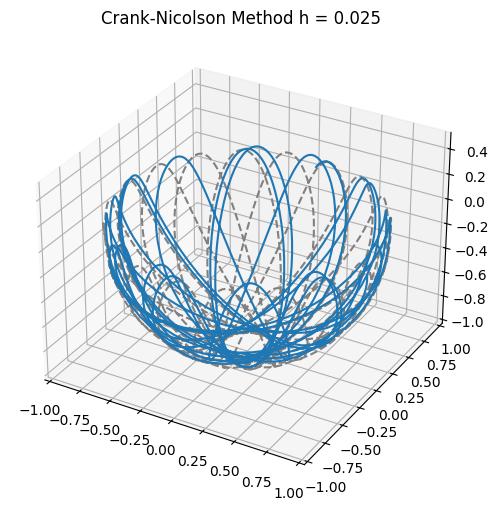

In [18]:
integrator = CNMethod(dt=0.025)
integrator.integrate(fvinc, [0, 25], y0= np.array([0, 1, 0, 0.8, 0, 1.2]))

plot_show(integrator.y, "Crank-Nicolson Method h = 0.025")

Eu fiquei tentando ajustar a função Crank-Nikolson pra chegar no mesmo erro do livro.
Inicialmente eu tinha escrito na marra fazendo o método de euler pra deduzir o f_n+1. Todavia,
o erro encontrado era 0.07 e não 0.09. Daí eu tentei copiar o livro que me deu 0.096, mas que deveria ser 0.092. 
Tendo em vista que a ordem de grandeza do erro está adequada em ambos os casos. Vou assumir que isso é devido ao funcionamento
da fsolve dentro do matlab. (Embora isso seja mais uma desculpa pra eu parar.)

Erro máximo com relação a esfera:  0.04305110868610118
Erro médio com relação a esfera:  0.028971171565379535


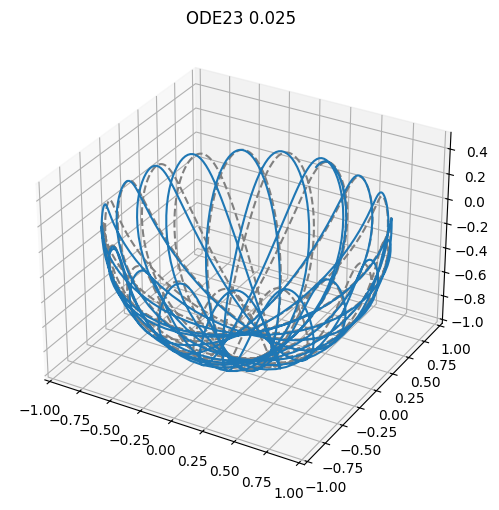

Erro máximo com relação a esfera:  2.505635772709347e-05
Erro médio com relação a esfera:  8.20634505714124e-06


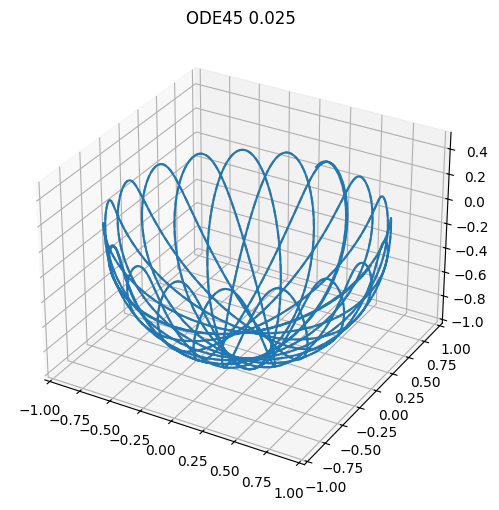

In [19]:
integrator = ode23(dt=0.025)
integrator.integrate(fvinc, [0, 25], y0= np.array([0, 1, 0, 0.8, 0, 1.2]))

plot_show(integrator.y, "ODE23 0.025")

integrator = ode45(dt=0.025)
integrator.integrate(fvinc, [0, 25], y0= np.array([0, 1, 0, 0.8, 0, 1.2]))

plot_show(integrator.y, "ODE45 0.025")

No livro ele faz um comparativo do ode45 e do ode23 com as mesmas condições iniciais e os mesmos spans. Como solicitou uma cópia dos exemplos. Aqui estamos.